<div class="alert alert-info">

<h1>This is the Backend</h1>
<h2>[Jump down to Frontend](#Parametric-Grid-Beam-Crib)</h2>

</div>

In [111]:
from ipytangle import tangle

from solid import (
    union,
    translate,
    cube,
    difference,
    cylinder,
    scad_render_to_file,
    scad_render,
    use,
    include,
    color,
)
from solid.utils import (
    right,
    left,
    up,
    down,
    bom_part,
    bill_of_materials,
)

In [112]:
import math

from IPython.html.widgets import (
    FloatSlider,
    DOMWidget,
)
from IPython.utils.traitlets import (
    link,
    Float,
    Unicode,
)  
from IPython.display import (
    display,
    Image
)

In [113]:
def _mattress_slat_gap(mattress_length, bed_length, mattress_width, bed_width):
    return math.sqrt(
        (bed_length - mattress_length) ** 2 +
        (bed_width - mattress_width) ** 2
    )

In [114]:
crib = tangle(
    mattress_vendor=["Ikea"],
    mattress_model=["VYSSA SLÖA"],
    mattress_width=27.5,
    mattress_length=52.0,
    mattress_depth=3.125,
    mattress_cost=49.99,

    beam_vendor=["Grid Beam Solutions"],
    beam_width=1.5,
    beam_lf_price=3,
    
    bed_width=(27.5,
        lambda mattress_width, beam_width: math.ceil(mattress_width / beam_width) * beam_width
    ),

    bed_length=(52.0,
        lambda mattress_length, beam_width: math.ceil(mattress_length / beam_width) * beam_width 
    ),
    
    max_mattress_slat_gap=1.5,
    mattress_slat_gap=(1.0, _mattress_slat_gap)
)
crib

In [130]:
include("MCAD/units.scad")
# inch to mm
inch = 25.4

class Crib(DOMWidget):
    filename = Unicode("crib-8-post-gen.scad")
    
    # above the mattress at its lowest
    mattress_to_top = Float(26)
    # space between slats
    max_slat_slat_gap = Float(2 + (3.0/8.0))
    # space between slats
    max_slat_mattress_gap = Float(1)
    
    # some ikea model
    mattress_width = Float(27.5)
    mattress_length = Float(52)
    mattress_depth = Float(3.125)
    
    beam_width = Float(1.5)
    
    beam_color = Unicode("BurlyWood")
    
    def __init__(self, *args, **kwargs):
        super(Crib, self).__init__(*args, **kwargs)
        self.on_trait_change(self._on_change)
    
    def _on_change(self, name, old, new):
        scad_render_to_file(
            self.scad(),
            self.filename
        )
    
    def scad(self):
        return union()(
            self.gridbeam(20)
        )
    
    def legs(self):
        return union()(
            
        )
    
    @bom_part("Grid Beam")
    def gridbeam(self, length=1):
        return zBeam(length)

crib = Crib()
crib.mattress_width = 28

In [166]:
import os
import subprocess
from tempfile import NamedTemporaryFile 

from solid import union


class Scad(object):
    GR = 1.61803398875

    def __init__(self, debug=False, width=None, height=None):
        self.debug = debug
        self._root = union()
        self.width = width or 1000
        self.height = height or self.width / self.GR

        
    def __enter__(self, debug=False):
        def _update(*scad_objects):
            self._root = union()(self._root, *scad_objects)
            
            if self.debug:
                print(scad_render(self._root).encode("utf-8"))

        return _update

    def __exit__(self, type, value, traceback):
        tmp = NamedTemporaryFile(suffix=".scad", delete=False)
        tmp_png = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
        try:
            scad_text = scad_render(self._root).encode("utf-8")
            tmp.write(scad_text)
            tmp.close()
            subprocess.Popen([
                "openscad",
                "--preview",
                "--imgsize={width},{height}".format(**self.__dict__),
                "--viewall",
                "--autocenter",
                "--color-scheme=Nature",
                "-o", tmp_png.name,
                tmp.name
            ]).communicate()
            display(Image(tmp_png.name))
        finally:
            os.unlink(tmp.name)
            os.unlink(tmp_png.name)

# with Scad() as see:
#     see(xBeam(4))

# Parametric Grid Beam Crib

[Grid Beam](http://gridbeam.biz/) is a modular approach for building structures. It's made of sticks and bolts. Building a Grid Beam crib for your little person is a life-long gift: she can have personalized furniture, kid-powered vehicles, and toys made from the reconfigured pieces.

## Mattress

The US Consumer Product Safety Commission (CPSC) [says](http://www.cpsc.gov/en/Business--Manufacturing/Business-Education/Business-Guidance/Full-Size-Baby-Cribs/):
> _a mattress used in a full-size crib must be at least 27 1/4 inches x 51 1/4 inches, with a thickness not exceeding 6 inches_

For example, [`mattress_vendor`](#:mattress_vendor)'s [`mattress_model`](#:mattress_model) is
[`mattress_width` in](#:mattress_width) $\times$ 
[`mattress_length` in](#:mattress_length) $\times$ 
[`mattress_depth` in](#:mattress_depth)
(and costs [`$(mattress_cost)`](#:mattress_cost)).

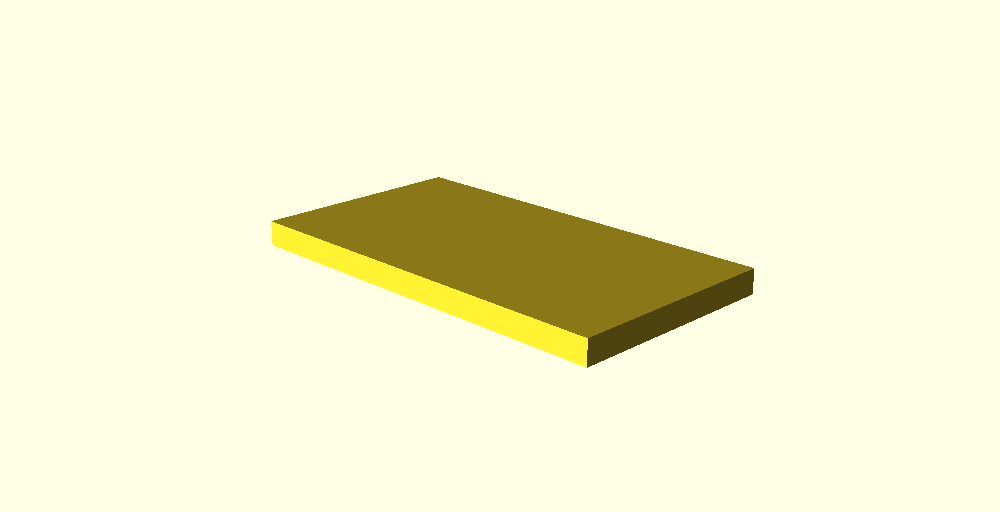

In [167]:
with Scad() as see:
    mattress = cube([dim * inch for dim in [
        crib.mattress_width, crib.mattress_length, crib.mattress_depth
    ]])
    see(mattress)

## Beams

Most grid beam projects will use just one size of square lumber. We'll use [`beam_width`in](#:beam_width) $\times$ [`beam_width`in](#:) lumber.
For example, [`beam_vendor`](#:beam_vendor) sells lengths at [`$(beam_lf_price)` per linear foot](#:beam_lf_price).

Grid Beam structures get their strength from _tri-joints_, or places where three sticks come together to form three right angles... or more/

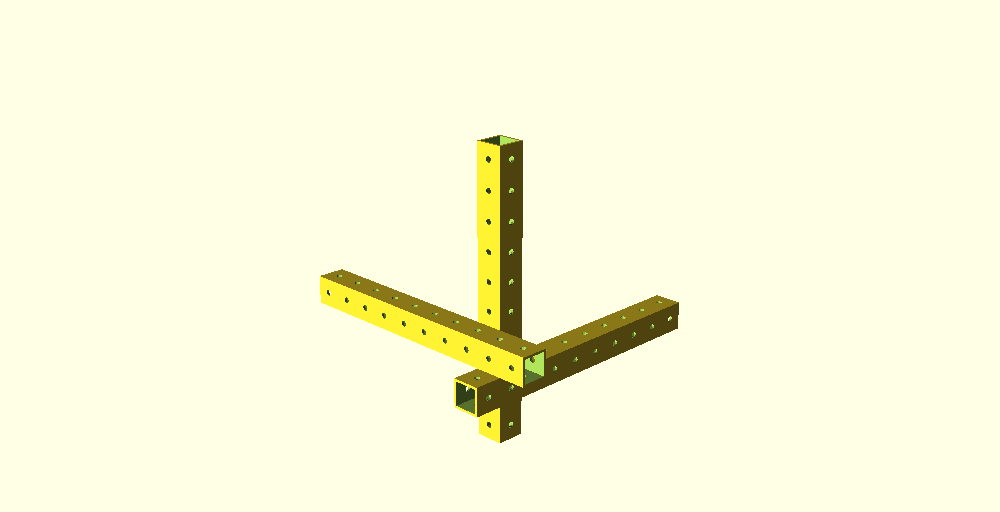

In [168]:
with Scad() as see:
    see(
        translateBeam([1,1,-3])(zBeam(10)),
        translateBeam([-1,0,-1])(xBeam(10)),
        translateBeam([0,-1,0])(yBeam(10))
    )


### Safety: Distance between Mattress and Sides 
To maximize reusability, all beams will be cut in [`beam_width`in](#:) increments. The nearest Grid Beamable-size is [`bed_width`in](#:) $\times$ [`bed_length`in](#:).

The CPSC [says](http://www.cpsc.gov/en/Safety-Education/Safety-Education-Centers/cribs/):
> _Make sure there are no gaps larger than two fingers between the sides of the crib and the mattress._


The maximum gap between the mattress and the sides of the crib (at the corner) is [`mattress_slat_gap` in](#:).

Assuming "two fingers" is about [`max_mattress_slat_gap` in](#:), [`mattress_slat_gap > max_mattress_slat_gap`](#:if)
**this is not safe**.
[](#:else)
this is safe.
[](#:endif)
